# Recurrent Neural Network

RNN is a type of artificial neural network designed for **sequential data** processing. Unlike traditional neural networks, RNNs have connections that form a directed cycle, allowing them to maintain a memory of **previous inputs** in their internal state. This makes RNNs well-suited for tasks involving sequences, such as natural language processing, speech recognition, and time series prediction.


Basic RNN modules consist of a single tanh layer in a repetitive pattern. However, their simplicity leads to a **limitation** known as **short memory**, making it challenging to preserve information from earlier time steps in extensive sequential data. To overcome this issue, advanced architectures like **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** are employed, excelling in retaining information over more extended periods.


In the **traditional neural network**, the inputs and the outputs are **independent** of each other, whereas the **output in RNN is dependent on prior elementals within the sequence**. Recurrent networks also **share parameters across each layer of the network**. In feedforward networks, there are different weights across each node. Whereas RNN shares the same weights within each layer of the network and during gradient descent, the weights and basis are **adjusted individually to reduce the loss**.

The input layer takes the initial input and sends it to the middle layer, which has multiple hidden layers. Each hidden layer has its own activation functions, weights, and biases. These parameters are standardized across the hidden layers, effectively creating a loop over one hidden layer instead of multiple.

Recurrent Neural Networks (RNNs) use **backpropagation through time (BPTT)** instead of traditional backpropagation. In backpropagation, the model adjusts the parameter by calculating errors from the output to the input layer. **BPTT sums the error at each time step as RNN shares parameters across each layer.**

In [6]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

set_seed(26)
np.random.seed(26)

In [7]:
# read dataset, convert date column as date format by using parse_dates
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
display(dataset.head())


,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [8]:
# analyze the basic statistics of the data set
display(dataset.describe())

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [9]:
# check if there is any missing values
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

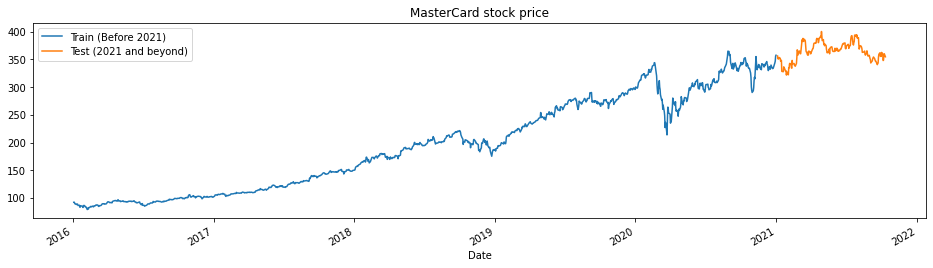

In [10]:
# Split the dataset into testing and training. An important point to note is that, 
# since it is a sequential dataset, random splitting won't work. 
# Therefore, we need to be careful about this. The test set needs to start from the endpoint of the training set.
# Plot trainig and test

tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

## Data Preprocessing

In [44]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [45]:
# Standardize the training set to avoid the outliers or anomalies. 
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [46]:
# The split_sequence function processes a training dataset, dividing it into two sets: 
# inputs (X_train) and outputs (y_train). 
# As an illustration, if we take the sequence [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] and set n_step to three, 
# the function will generate three input timestamps (1, 2, 3) with a corresponding output of 4.

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [47]:
# print(len(X_train)) 
# print(len(X_train[0])) 
# print(len(y_train)) 
# print(len(y_train[0])) 

print((X_train.shape)) 
print((X_train[0].shape)) 
print((y_train.shape)) 
print((y_train[0].shape)) 

1199
60
1199
1
(1199, 60, 1)
(60, 1)
(1199, 1)
(1,)


In [48]:
# Reshaping X_train for model
# It reshapes the input data into a structure with 60 timesteps (columns) and 1 feature (output). 
# This reshaping is done to match the input requirements of certain types of neural network models, such as LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [49]:
# print(len(X_train)) 
# print(len(X_train[0])) 
# print(len(y_train)) 
# print(len(y_train[0])) 

print((X_train.shape)) 
print((X_train[0].shape)) 
print((y_train.shape)) 
print((y_train[0].shape)) 

1199
60
1199
1
(1199, 60, 1)
(60, 1)
(1199, 1)
(1,)


### Limitations of RNN
Simple RNN models usually run into two major issues. These issues are related to gradient, which is the slope of the loss function along with the error function.

Vanishing Gradient problem occurs when the gradient becomes so small that updating parameters becomes insignificant; eventually the algorithm stops learning.
Exploding Gradient problem occurs when the gradient becomes too large, which makes the model unstable. In this case, larger error gradients accumulate, and the model weights become too large. This issue can cause longer training times and poor model performance.
The simple solution to these issues is to reduce the number of hidden layers within the neural network, which will reduce some complexity in RNNs. These issues can also be solved by using advanced RNN architectures such as LSTM and GRU.


RNN models often face two significant challenges linked to the gradient – the slope of the loss function in relation to the error function.

1 - Vanishing Gradient Problem:
Occurs when the gradient becomes extremely small, rendering parameter updates insignificant.

2 - Exploding Gradient Problem:

Arises when the gradient becomes excessively large, causing model instability.
Results in the accumulation of larger error gradients and oversized model weights.

### Solutions

1 - reduce the number of hidden layers in the neural network

2- use more advanced RNN architectures like LSTM and GRU 

## Long Short-Term Memory (LSTM)

In [50]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 3s 35ms/step - loss: 0.0123
Epoch 2/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0020
Epoch 3/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0021
Epoch 4/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0018
Epoch 5/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0013
Epoch 6/50
38/38 [==============================] - 1s 35ms/step - loss: 0.0013
Epoch 7/50
38/38 [==============================] - 1s 37ms/step - loss: 9.8342e-04
Epoch 8/50
38/38 [==============================] - 1s 37ms/step - loss: 9.8083e-04
Epoch 9/50
38/38 [==============================] - 1s 38ms/step - loss: 9.3161e-04
Epoch 10/50
38/38 [==============================] - 1s 37ms/step - loss: 9.0346e-04
Epoch 11/50
38/38 [==============================] - 1s 35ms/step - loss: 8.3313e-04
Epoch 12/50
38/38 [==============================] - 1s 37ms/step - loss: 8.8381e-04
Epoch 13/50
3

In [13]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 1s 19ms/step


In [14]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

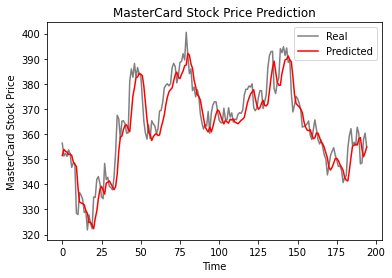

In [16]:
plot_predictions(test_set,predicted_stock_price)

In [17]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.57.


In [18]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 4s 53ms/step - loss: 0.0203
Epoch 2/50
38/38 [==============================] - 2s 44ms/step - loss: 0.0017
Epoch 3/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0017
Epoch 4/50
38/38 [==============================] - 2s 44ms/step - loss: 0.0014
Epoch 5/50
38/38 [==============================] - 2s 44ms/step - loss: 0.0010
Epoch 6/50
38/38 [==============================] - 2s 44ms/step - loss: 0.0012
Epoch 7/50
38/38 [==============================] - 2s 44ms/step - loss: 7.3022e-04
Epoch 8/50
38/38 [==============================] - 2s 44ms/step - loss: 9.3992e-04
Epoch 9/50
38/38 [==============================] - 2s 44ms/step - loss: 7.7447e-04
Epoch 10/50
38/38 [==============================] - 2s 43ms/step - loss: 8.7900e-04
Epoch 11/50
38/38 [==============================] - 2s 42ms/step - loss: 7.1808e-04
Epoch 12/50
38/38 [==============================] - 2s 47ms/step - loss: 6.7235e-04
Epoch 13/50
3

7/7 [==============================] - 0s 11ms/step


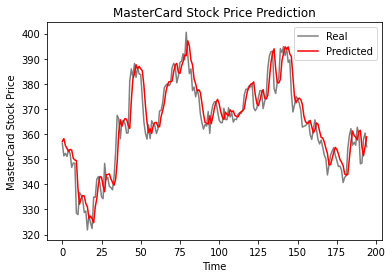

In [20]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [21]:
return_rmse(test_set,GRU_predicted_stock_price)



The root mean squared error is 5.92.
